<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/Visualizing_the_Solution_Path_on_2d_Synthetic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import matplotlib.pyplot as plt

In [3]:
!wget -O my_logit.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_logit.py

import my_logit

--2023-11-15 02:57:13--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_logit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5902 (5.8K) [text/plain]
Saving to: ‘my_logit.py’

my_logit.py         100%[===================>]   5.76K  --.-KB/s    in 0s      

2023-11-15 02:57:13 (55.7 MB/s) - ‘my_logit.py’ saved [5902/5902]



In [4]:
!wget -O my_module.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_module.py

import my_module

--2023-11-15 02:57:13--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_module.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4022 (3.9K) [text/plain]
Saving to: ‘my_module.py’

my_module.py        100%[===================>]   3.93K  --.-KB/s    in 0s      

2023-11-15 02:57:13 (43.1 MB/s) - ‘my_module.py’ saved [4022/4022]



# Visualizing the Solution Path

We use Legendre polynomials as the basis vectors for $\Phi(\lambda)$.

In [5]:
phi_lam = my_module.phi_lam_Legendre

In [8]:
lam_max = 1
lam_min = 0
num_grid = 2**10
epochs = 5000
lr = 0.5**6

In [10]:
#some synthetic data for instance below
np.random.seed(8675309)
torch.manual_seed(8675309) #Ensures linear layer initializes deterministically for reproducibility

X_syn, y_syn = my_logit.gen_data(100, 100, 2)

In [11]:
#The pytorch built-in binary cross-entropy loss
criterion = torch.nn.BCELoss()
input_dim_syn = X_syn.shape[1]

In [12]:
syn_data = my_logit.Regression_Data(X_syn, y_syn)
syn_data_loader = my_logit.DataLoader(syn_data, batch_size=len(syn_data), shuffle=False, )

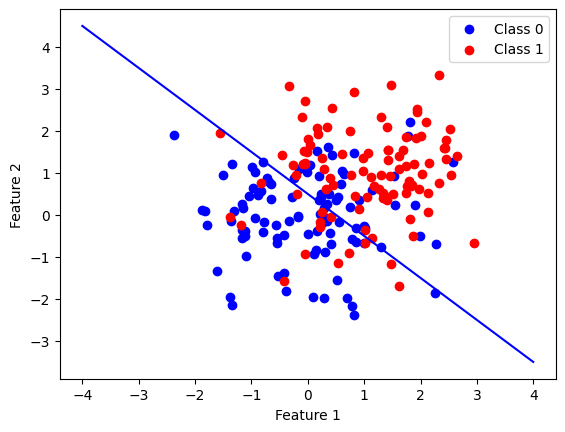

In [ ]:
# Separate data points by class
class_0 = X_syn[y_syn == 0]
class_1 = X_syn[y_syn == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], c='b', marker='o', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], c='r', marker='o', label='Class 1')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')

# plot perfect separator
x_1 = np.linspace(-4, 4, 100)
x_2 = -x_1 + .5
plt.plot(x_1, x_2, color='blue')

# Show the plot
plt.show()

Create the exact solution path with naive grid search on $2^{10}$ grid points.

In [ ]:
# models, num_itr = naive_grid_search(lam_min=lam_min, lam_max=lam_max,
#                                     num_grid=num_grid, epochs=epochs,
#                                     trainDataLoader=syn_data_loader,
#                                     data_input_dim=input_dim_syn,
#                                     lr=lr, SGD=False)

In [ ]:
# thetas = []
# for model in models:
#     thetas.append(model.linear.weight.data.detach().numpy()[0])
# thetas = np.array(thetas)
# print(thetas.shape)

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/syn_exact_soln_list.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['feature 1', 'feature 2'])

#     # Write the data from your lists
#     for i in range(len(thetas)):
#         csv_writer.writerow([thetas[i,0], thetas[i,1]])

In [ ]:
import pandas as pd
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/syn_exact_soln_list.csv'
thetas = pd.read_csv(csv_file_path)
thetas = np.array(thetas)

Text(0, 0.5, 'Feature 2')

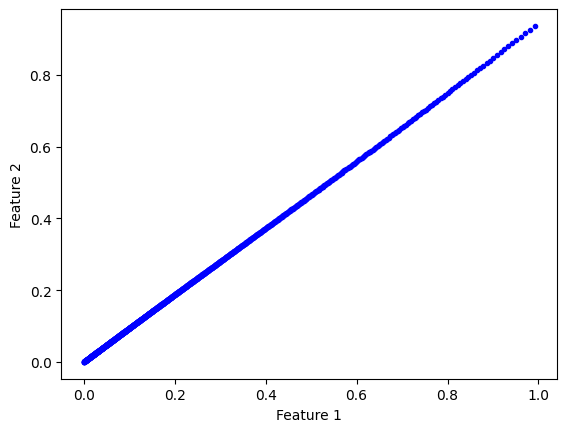

In [ ]:
# Create a scatter plot
plt.scatter(thetas[:, 0], thetas[:, 1], c='b', marker='.', label='exact solution path')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

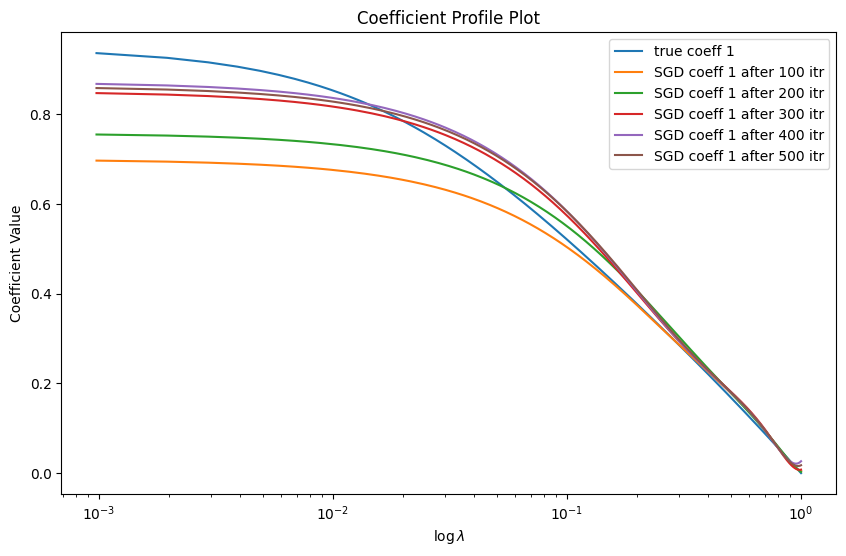

In [ ]:
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, thetas[:,1], label=f'true coeff {1}')

# build the model
basis_dim = 5
epoch = 500
lr = 0.5**4
np.random.seed(8675309)
torch.manual_seed(8675309)
model = my_module.Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()

for t in range(epoch):
    my_module.train_SGD(syn_data_loader, model, criterion, optimizer)
    if (t+1) % 100 == 0:
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        # Plot coefficient profiles
        plt.plot(lambdas, thetas_SGD[:,1], label=f'SGD coeff {1} after {t+1} itr')


# Set plot labels and title
plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\log \\lambda$')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Profile Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
basis_dim = 5
epoch = 500
lr = 0.5**4
np.random.seed(8675309)
torch.manual_seed(8675309)
model = my_module.Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()

for t in range(epoch):
    my_module.train_SGD(syn_data_loader, model, criterion, optimizer)

In [ ]:
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)
thetas_SGD = []
for lam in lambdas:
    thetas_SGD.append(model(lam).data.detach().numpy())
thetas_SGD = np.array(thetas_SGD)

In [ ]:
thetas_SGD[:, 0]

array([-0.02457257, -0.02402914, -0.0234919 , ..., -0.724197  ,
       -0.72847533, -0.7327739 ], dtype=float32)

Text(0, 0.5, 'Feature 2')

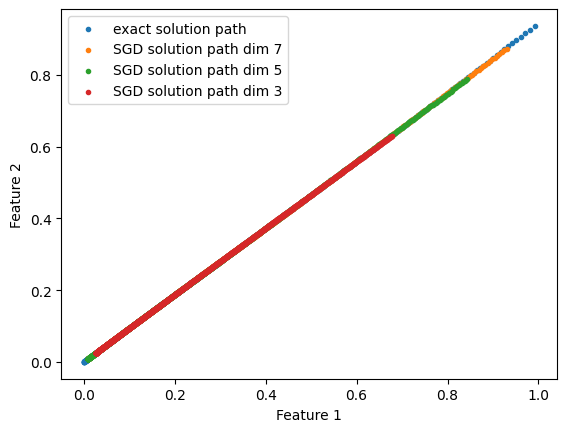

In [ ]:
# Create a scatter plot
plt.scatter(thetas[:, 0], thetas[:, 1], marker='.', label='exact solution path')

epoch = 500
lr = 0.5**4

delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

np.random.seed(8675309)
torch.manual_seed(8675309)

for basis_dim in range(7, 2, -2):
    model = my_module.Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epoch):
        my_module.train_SGD(syn_data_loader, model, criterion, optimizer)

    thetas_SGD = []
    for lam in lambdas:
        thetas_SGD.append(model(lam).data.detach().numpy())
    thetas_SGD = np.array(thetas_SGD)
    plt.scatter(thetas_SGD[:, 1], thetas_SGD[:, 2], marker='.', label=f'SGD solution path dim {basis_dim}')

plt.legend()
# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')